### Vamos a cargar los datos

In [1]:
from arreglo_datos import vectorDatos
from transformacion import transformacion_datos

In [2]:
path = 'C:\\Users\\masan\\Desktop\\Mario\\ESFM\\Octavo Semestre\\Servicio Social\\Etiquetas'
dic_nombre_marcas = vectorDatos(path)

#### Vamos a dividir los datos en conjunto de entrenamiento y testeo (80-20).

In [3]:
# Vamos a extraer los datos de cada imagen para poder hacer el split de datos.
vectorDeDatos_completos = []
nombreDeImagenes = []
for key in dic_nombre_marcas.keys():
    vectorDeDatos_completos.append(dic_nombre_marcas[key])
    nombreDeImagenes.append(key)

In [4]:
modo_lineas_borde = True

if modo_lineas_borde:
    vectorDeDatos = []
    for vector in vectorDeDatos_completos:
        vector_temp = [vector[0], vector[1],  vector[-1]]
        vectorDeDatos.append(vector_temp)

In [5]:
vectorDeDatos[1043]

[[1, 0, 0, 1, 0, 215, 498, 388, 393],
 [1, 0, 0, 0, 1, 959, 392, 656, 370],
 ['2019_12_01_150643_008_resized.png']]

In [6]:
entrenamiento = int(0.8*len(vectorDeDatos))
datos_entrenamiento = vectorDeDatos[:entrenamiento]
datos_testeo = vectorDeDatos[entrenamiento:]

#### Vamos a cargar los datos con su respectiva transformación.

In [7]:
# Training
datos_transformados_training = []
for i in range(len(datos_entrenamiento)):
    try:
        sample = transformacion_datos(datos_entrenamiento[i])
        datos_transformados_training.append(sample)
    except ValueError:
        pass
    

# Testeo
datos_transformados_testeo = []
for i in range(len(datos_testeo)):
    try:
        sample = transformacion_datos(datos_testeo[i])
        datos_transformados_testeo.append(sample)
    except ValueError:
        pass
    

Vamos a hacer la funcion para graficar los puntos en las imagenes

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def graficar_puntos(image, puntos):
    
    plt.imshow(np.asarray(image), cmap='gray')
    # Excluimos los puntos que no vamos a graficar, que en este caso son (0.00, 0.00)
    puntos = [x.tolist() for x in puntos if (x[0]!= 0.0) and (x[1]!= 0.0)]
    puntos = np.array(puntos)
    puntos = torch.from_numpy(puntos)
    plt.scatter(puntos[:,0], puntos[:,1], s=20, marker='.', c='r')
    #plt.axis('off')


Bad key "legend.title_fontsize" on line 22 in
C:\Users\masan\.matplotlib\stylelib\notebook.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### Prueba

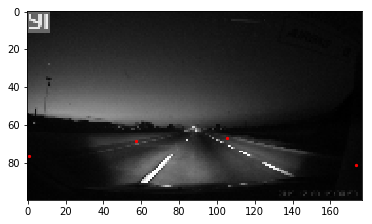

In [9]:
# Imagen aleatoria a imprimir
i = np.random.randint(0, len(datos_transformados_training))

img = datos_transformados_training[i]['image']
puntos = datos_transformados_training[i]['puntos']
graficar_puntos(img[0], puntos)

# TODO:
- ~~Inicializacion de los pesos~~
- ~~Identificar los 4 puntos de los bordes.~~
- Graficar la perdida dado el paso de las epocas.
- Revisar la normalizacion de la salida de red
- Calcular los parametros de la red
    - Aritmetica de las convoluciones...
- Borrar los datos de las imagenes que tengan dos veces la misma etiqueta

---

In [22]:
from modelo import Net
import torch.nn as nn
import torch.nn.functional as F

#check for GPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
# Assume that we are on a CUDA machine, then this should print a CUDA device:

dropout_prob = 0.5
net = Net(dropout_prob)
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1000, out_features=524, bias=True)
  (drop6): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=524, out_features=8, bias=True)
)


In [23]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

for i in range(4):
    sample = datos_transformados_testeo[i]
    print(i, sample['image'].size(), sample['puntos'].size())

0 torch.Size([1, 100, 177]) torch.Size([4, 2])
1 torch.Size([1, 100, 177]) torch.Size([4, 2])
2 torch.Size([1, 100, 177]) torch.Size([4, 2])
3 torch.Size([1, 100, 177]) torch.Size([4, 2])


In [24]:
batch_size = 32

train_loader = DataLoader(datos_transformados_training, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [25]:
batch_size = 5 #no modificar

test_loader = DataLoader(datos_transformados_testeo, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [26]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['puntos']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # wrap them in a torch Variable
        images = Variable(images)    
        images = images.to(device)

        # forward pass to get net output
        output_pts = net(images)
        images = images.to(device)#cpu()
        output_pts = output_pts.to(device)#cpu()
        
        # reshape to batch_size x 28 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 4, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [27]:
test_images, test_outputs, gt_pts = net_sample_output()

In [28]:
# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([5, 1, 100, 177])
torch.Size([5, 4, 2])
torch.Size([5, 4, 2])


In [29]:
def graficar_todos_puntos(image, puntos, gt_pts=None):
    plt.imshow(image, cmap='gray')
    # Excluimos los puntos que no vamos a graficar, que en este caso son (0.00, 0.00)
    puntos = [x.tolist() for x in puntos if (x[0]!= 0.0) and (x[1]!= 0.0)]
    puntos = np.array(puntos)
    puntos = torch.from_numpy(puntos)
    plt.scatter(puntos[:,0], puntos[:,1], s=200, marker='.', c='m')  
    # plot ground truth points as green pts
    if gt_pts is not None:
        #gt_pts = gt_pts.to(device)
        gt_pts = [x.tolist() for x in gt_pts if (x[0]!= 0.0) and (x[1]!= 0.0)]
        gt_pts = np.array(gt_pts)
        gt_pts = torch.from_numpy(gt_pts)
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=50, marker='.', c='g')

In [30]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=batch_size):

    for i in range(batch_size):
        plt.figure(figsize=(50,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data  # get the image from it's wrapper
        #image = image.numpy()   # convert to numpy array from a Tensor
        #image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu()
        #predicted_ket_pts.to(device)
        
        # undo normalization of keypoints  
        #predicted_key_pts = predicted_key_pts
        
        # plot ground truth points for comparison, if they exist

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts
        
        # call show_all_keypoints
        graficar_todos_puntos(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
#test_images.cpu()
#test_outputs.cpu()
#gt_pts.cpu()

#visualize_output(test_images, test_outputs, gt_pts)

---

In [31]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss().to(device)

init_factor = 0.01
learning_rate = 0.001 * init_factor

optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [32]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        scheduler.step()

        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['puntos']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = Variable(key_pts.type(torch.FloatTensor))
            images = Variable(images.type(torch.FloatTensor))

            #images, key_pts = Variable(images), Variable(key_pts)    
            images, key_pts = images.to(device), key_pts.to(device)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()
            
            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
                

    print('Finished Training')

In [33]:
n_epochs = 25

In [43]:
train_net(n_epochs)

C:\Users\masan\miniconda3\envs\cv-nd\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1, Batch: 10, Avg. Loss: 38.5384921875
Epoch: 1, Batch: 20, Avg. Loss: 17.197956909179688
Epoch: 1, Batch: 30, Avg. Loss: 15.032157348632813
Epoch: 1, Batch: 40, Avg. Loss: 13.583385498046875
Epoch: 2, Batch: 10, Avg. Loss: 14.695291625976562
Epoch: 2, Batch: 20, Avg. Loss: 14.701523803710938
Epoch: 2, Batch: 30, Avg. Loss: 13.626847900390626
Epoch: 2, Batch: 40, Avg. Loss: 12.323812133789062
Epoch: 3, Batch: 10, Avg. Loss: 12.848212768554687
Epoch: 3, Batch: 20, Avg. Loss: 13.530397583007813
Epoch: 3, Batch: 30, Avg. Loss: 12.400717529296875
Epoch: 3, Batch: 40, Avg. Loss: 11.573223022460937
Epoch: 4, Batch: 10, Avg. Loss: 10.9503330078125
Epoch: 4, Batch: 20, Avg. Loss: 9.929495056152344
Epoch: 4, Batch: 30, Avg. Loss: 8.823130187988282
Epoch: 4, Batch: 40, Avg. Loss: 9.768945007324218
Epoch: 5, Batch: 10, Avg. Loss: 8.38275732421875
Epoch: 5, Batch: 20, Avg. Loss: 8.953236389160157
Epoch: 5, Batch: 30, Avg. Loss: 8.394016967773437
Epoch: 5, Batch: 40, Avg. Loss: 8.71870678710

In [44]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_100_puntos_imagenes_nuevas.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [34]:
load_parameters = True

if(load_parameters):
    state_dict = torch.load('saved_models/keypoints_model_100_puntos_imagenes_nuevas.pt')
    #print(state_dict.keys())
    net.load_state_dict(state_dict)

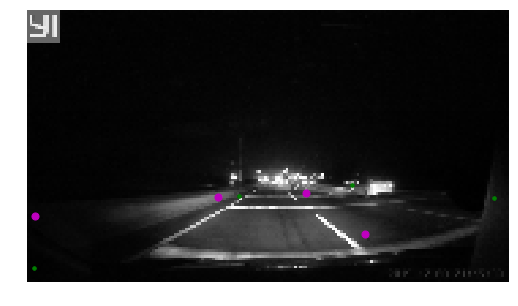

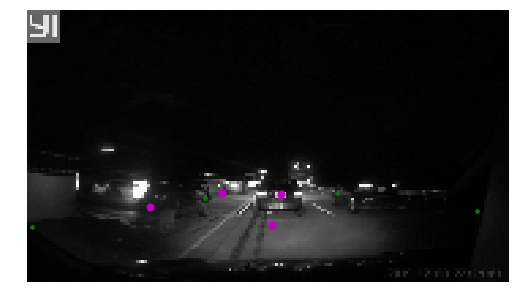

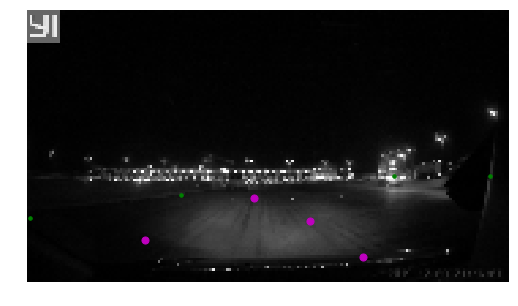

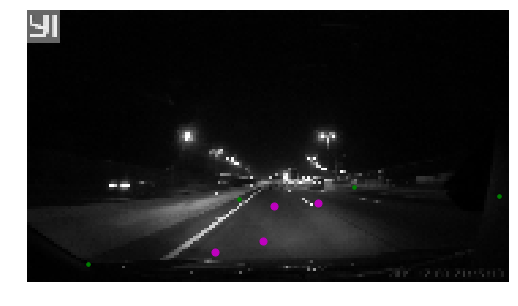

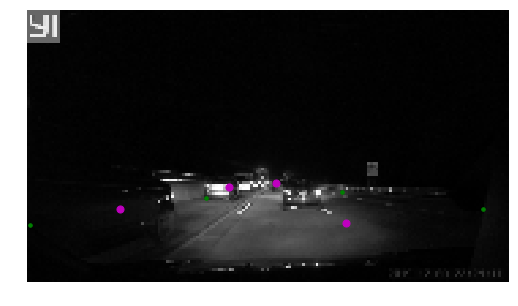

In [39]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)